In [23]:
import os
from PIL import Image
import glob

import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras import metrics

In [3]:
def load_unlabeled_dataset():
    images = []
    # Labeled data
    for f in glob.iglob("./dataset/train/*/*"):
        images.append(np.asarray(Image.open(f)))
    
    # Unlabeled data
    for f in glob.iglob("./dataset/unlabeled/*"):
        images.append(np.asarray(Image.open(f)))
        
    images = np.array(images)
    return images

In [4]:
# Load unlabeled and labeled train data
unlabeled_data = load_unlabeled_dataset()

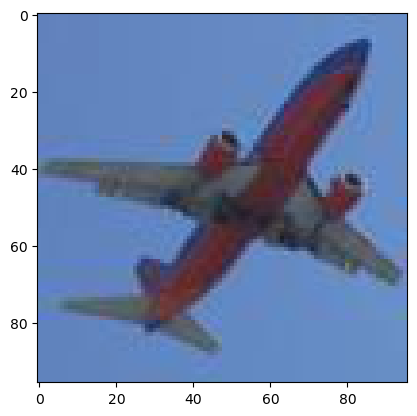

In [5]:
# View an example of an image
plt.imshow(unlabeled_data[0])

In [10]:
def normalize_images(img):
    #gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_normalized = cv.normalize(img, None, 0, 1.0, cv.NORM_MINMAX, dtype=cv.CV_32F)
    #img_normalized = np.reshape(img_normalized, (96, 96, 1))
    return img_normalized

In [11]:
# Normalize the images
#unlabeled_data = [normalize_and_greyscale(img) for img in unlabeled_data]
#unlabeled_data = np.asarray(unlabeled_data)
unlabeled_data = normalize_images(unlabeled_data)

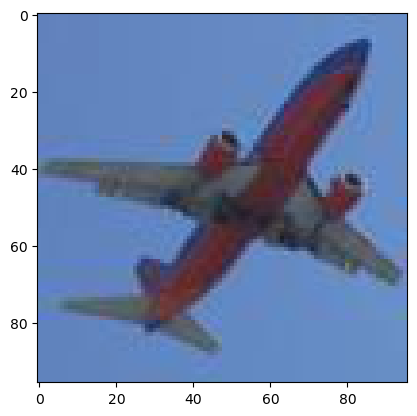

In [12]:
plt.imshow(unlabeled_data[0])

In [13]:
# Split into train and test sets
x_train, x_test, _, _ = train_test_split(unlabeled_data, unlabeled_data, test_size=0.1)

In [69]:
def build_autoencoder():
    model = Sequential()
    model.add(layers.Input(shape=(96, 96, 3)))
    
    # Encoder
    model.add(layers.Conv2D(32, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(48, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    
    # Decoder
    model.add(layers.Conv2DTranspose(64, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(48, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(32, (5, 5), (2, 2), activation="tanh", padding="same"))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(3, (5, 5), (2, 2), activation="sigmoid", padding="same"))
    
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=[metrics.RootMeanSquaredError()])
    
    return model

In [70]:
# Build autoencoder model
model = build_autoencoder()
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 48, 48, 32)        2432      
_________________________________________________________________
batch_normalization_146 (Bat (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 24, 24, 48)        38448     
_________________________________________________________________
batch_normalization_147 (Bat (None, 24, 24, 48)        192       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 12, 12, 64)        76864     
_________________________________________________________________
batch_normalization_148 (Bat (None, 12, 12, 64)        256       
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 6, 6, 128)       

In [19]:
class DataGenerator(Sequence):
    def __init__(self, x_set, batch_size=64):
        self.x = x_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.floor(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        return batch_x, batch_x

In [71]:
early_stopping_monitor = EarlyStopping(
    monitor='val_root_mean_squared_error',
    min_delta=0.005,
    patience=20,
    verbose=0,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

train_gen = DataGenerator(x_train)
test_gen = DataGenerator(x_test)
history = model.fit(
    train_gen,
    epochs=50,
    callbacks=[early_stopping_monitor],
    validation_data=test_gen
)

model.save("./model_weights/multicolor/3-3-256")

Epoch 1/50
1546/1546 [==============================] - 81s 52ms/step - loss: 0.5370 - root_mean_squared_error: 0.0978 - val_loss: 0.5333 - val_root_mean_squared_error: 0.0866
Epoch 2/50
1546/1546 [==============================] - 60s 39ms/step - loss: 0.5248 - root_mean_squared_error: 0.0716 - val_loss: 0.5271 - val_root_mean_squared_error: 0.0734
Epoch 3/50
1546/1546 [==============================] - 56s 36ms/step - loss: 0.5215 - root_mean_squared_error: 0.0627 - val_loss: 0.5220 - val_root_mean_squared_error: 0.0610
Epoch 4/50
1546/1546 [==============================] - 57s 37ms/step - loss: 0.5199 - root_mean_squared_error: 0.0578 - val_loss: 0.5201 - val_root_mean_squared_error: 0.0561
Epoch 5/50
1546/1546 [==============================] - 56s 36ms/step - loss: 0.5186 - root_mean_squared_error: 0.0538 - val_loss: 0.5189 - val_root_mean_squared_error: 0.0519
Epoch 6/50
1546/1546 [==============================] - 56s 37ms/step - loss: 0.5178 - root_mean_squared_error: 0.0510 -

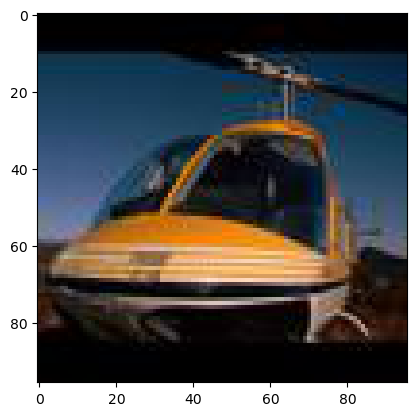

In [67]:
plt.imshow(x_test[108])

In [72]:
prediction = model.predict(x_test)

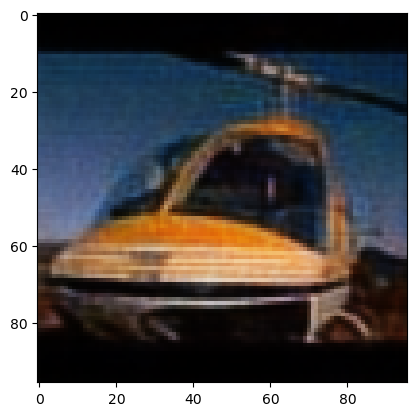

In [73]:
plt.imshow(prediction[108])